In [1]:
import sys,os, math, glob, time  
from builtins import zip  
sys.path.append('/data/fragosta/work/lsst/sims_maf_contrib-master/')  
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from scipy.stats import norm, uniform  
from sklearn.neighbors import KernelDensity  
import lsst.sims.maf.slicers as slicers  
import lsst.sims.maf.metrics as metrics  
import lsst.sims.maf.metricBundles as metricBundles  
import lsst.sims.maf.db as db  
import lsst.sims.maf.plots as plots  
from lsst.sims.utils import equatorialFromGalactic, galacticFromEquatorial  
from lsst.sims.maf.metrics import BaseMetric, starDensity   
from lsst.sims.maf.utils import m52snr 
from opsimUtils import *  
from astropy.io import fits   
from sklearn.utils import shuffle
import sklearn.mixture as GMM  
import astrometry_metrics
%matplotlib inline 

In [2]:
from lsst.sims.maf.utils.opsimUtils import getSimData
from lsst.sims.maf.utils.mafUtils import radec2pix

In [3]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook. 
         raise Exception('Please provide your username!  See the top of the notebook.') 

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/' 
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username) 

if not os.path.exists(os.path.abspath(outDir)): 
     os.mkdir(os.path.abspath(outDir)) 
dbRuns = show_opsims(dbDir) 
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

In [4]:
U=np.arange(-100,100,5) 
W=np.arange(-100,100,5) 
V=np.arange(-100,100,5) 
def readfile( filename='', colsname=['']): 
    if 'csv' in filename: 
        #print('reading {}'.format(filename)) 
        data = pd.read_csv(filename, header=0, names = colsname ) 
    elif 'fits' in filename: 
        #print('reading {}'.format(filename)) 
        hdul = fits.open(filename) 
        data = hdul[1].data 
    elif ['txt', 'dat'] in filename: 
        #print('reading {}'.format(filename)) 
        data = {k:[] for k in colsname} 
        f = open(filename) 
        righe = f.readlines() 
        for line in righe: 
            line.split() 
            for i, k in enumerate(colsname): 
                data[k].append(float(line[i]))                 
    elif 'json'in filename: 
        print('not implemented to read .json extention') 
    return data 

In [351]:
names = ['ra', 'dec', 'seeing']    
npoint = 1  #  Note, we are going to loop over each object, so try not to make this a crazy huge number. 
transienobj = np.zeros(npoint, dtype=list(zip(names, [float]*len(names))))
# to random selection of position in the sky
l = 150.09671833  # np.random.rand(npoint)*2+30.
b = 2.18284020 # np.random.rand(npoint)*1+1.
#transienobj['ra'], transienobj['dec'] = equatorialFromGalactic(l,b) 
transienobj['ra'], transienobj['dec'] = l, b
#transObjects['seeing'] = np.random.rand(npo

In [352]:
surveyDuration = 2
filename = 'data.csv' 
colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX'] 
data = readfile(filename, colsname) 
#transienobj= pd.DataFrame({'ra':data['RA'], 'dec':data['DEC']}) 
metric1 = astrometry_metrics.LSPMmetric(metricName= 'Like_point',f='g',m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', seeingCol='seeingFwhmGeom',percentiles=[2.5,97.5,50],surveyduration = 2,dataout=True) 
metric2 = astrometry_metrics.TransienPM(Mmin=18,Mmax=24,f='g',m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', seeingCol='seeingFwhmGeom',surveyduration=2) 
metric3 = astrometry_metrics.confusionmetric(metricName='conf44',filename='data.csv', colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX'],snr_lim=5,mode='distance', surveyduration = 2, MagIterLim=[1,2,1],m5Col='fiveSigmaDepth', mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom',dataout=False) 
star = starDensity.StarDensityMetric()
slicer3 = slicers.UserPointsSlicer(transienobj['ra'], transienobj['dec']) 
sqlconstraint ='night<{} and note not like  "DD%" '.format(365*surveyDuration) 
slicer = slicers.HealpixSlicer(nside=16) 
metricSky1 = metricBundles.MetricBundle(metric1,slicer3,sqlconstraint) 
metricSky2 = metricBundles.MetricBundle(metric2,slicer,sqlconstraint) 
metricSky3 = metricBundles.MetricBundle(metric3,slicer,sqlconstraint)
starDens = metricBundles.MetricBundle(star,slicer,sqlconstraint)
#bundleDict={'transient':metricSky2, 'confusion': metricSky3} 
#bundleDict={'like':metricSky1,'star':starDens}
bundleDict={'like': metricSky1}

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [353]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username)

# below I am only going to run metrics on the first five opsims
for i, run in enumerate(dbRuns):
    print('##############\n')
    print('N_{}, {} is running\n'.format(i+1,run))
    print('##############\n')
    start_time = time.time()
    # must set run name for each opSim to store metric data into
    # separate files
    #metricSky1.setRunName(run)
    #starDens.setRunName(run)
    #metricSky2.setRunName(run)
    metricSky3.setRunName(run)
    group = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    group.runAll()
    print( '--- {:.2f} minutes ---\n'.format((time.time() - start_time)/60))
    print('####################\n')

##############

N_1, dcr_nham1_ugri_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 408173 visits
Running:  ['like']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 0.19 minutes ---

####################

##############

N_2, rolling_mod6_sdf_0.20_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint night<730 and note not like  "DD%"  for columns ['night', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'seeingFwhmGeom', 'observationStartMJD']
Found 410015 visits
Running:  ['like']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 0.12 minutes ---

####################

##############

N_3, wfd_depth_scale0.95_noddf_v1.5_10yrs is running

##############

Queryin

In [354]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username)
resultDbPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username)
# get a dictionary of resultDb from given directory 
resultDbs2 = getResultsDbs(outDir) 

# the following line will be useful if you did not run MAF on all 75 opsims 
runNames = list(resultDbs2.keys()) 
bundleDicts = {} 
for runName in dbRuns:# metric_runs: 
     bundleDicts[runName] = bundleDictFromDisk(resultDbs2[runName], runName, metricDataPath)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slic

In [355]:
for k in dbRuns:
    print(bundleDicts[k].keys())

dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric'), (5, 'conf44'), (6, 'Like_point')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric'), (5, 'conf44'), (6, 'Like_point')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric'), (5, 'conf44'), (6, 'Like_point')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric'), (5, 'conf44'), (6, 'Like_point')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric'), (5, 'conf44'), (6, 'Like_point')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric'), (5, 'conf44'), (6, 'Like_point')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric'), (5, 'conf44'), (6, 'Like_point')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric'), (5,

In [309]:
dbRuns

['dcr_nham1_ugri_v1.5_10yrs',
 'rolling_mod6_sdf_0.20_v1.5_10yrs',
 'wfd_depth_scale0.95_noddf_v1.5_10yrs',
 'u60_v1.5_10yrs',
 'footprint_stuck_rollingv1.5_10yrs',
 'filterdist_indx4_v1.5_10yrs',
 'wfd_depth_scale0.70_noddf_v1.5_10yrs',
 'daily_ddf_v1.5_10yrs',
 'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs',
 'goodseeing_gz_v1.5_10yrs',
 'filterdist_indx1_v1.5_10yrs',
 'footprint_standard_goalsv1.5_10yrs',
 'footprint_big_sky_dustv1.5_10yrs',
 'footprint_bluer_footprintv1.5_10yrs',
 'twilight_neo_mod4_v1.5_10yrs',
 'goodseeing_gi_v1.5_10yrs',
 'footprint_big_wfdv1.5_10yrs',
 'dcr_nham2_ugr_v1.5_10yrs',
 'short_exp_5ns_5expt_v1.5_10yrs',
 'goodseeing_griz_v1.5_10yrs',
 'twilight_neo_mod1_v1.5_10yrs',
 'bulges_cadence_bulge_wfd_v1.5_10yrs',
 'third_obs_pt120v1.5_10yrs',
 'wfd_depth_scale0.95_v1.5_10yrs',
 'wfd_depth_scale0.85_noddf_v1.5_10yrs',
 'footprint_no_gp_northv1.5_10yrs',
 'footprint_big_skyv1.5_10yrs',
 'footprint_newBv1.5_10yrs',
 'baseline_2snaps_v1.5_10yrs',
 'footprint_big_sky_n

### Fom bar plot

In [356]:
df={}
for key in dbRuns:
    df[key]={}
    for (i,metric) in bundleDicts[key].keys():
        arr = bundleDicts[key][(i,metric)].metricValues.data
        arr_ = arr[arr!= None]
        if isinstance(arr_[0], dict):
            df[key][metric]=pd.DataFrame.from_records(arr_)
        else:
            df[key][metric]= bundleDicts[key][(i,metric)].metricValues[np.where(bundleDicts[key][(i,metric)].metricValues.mask==False)]

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


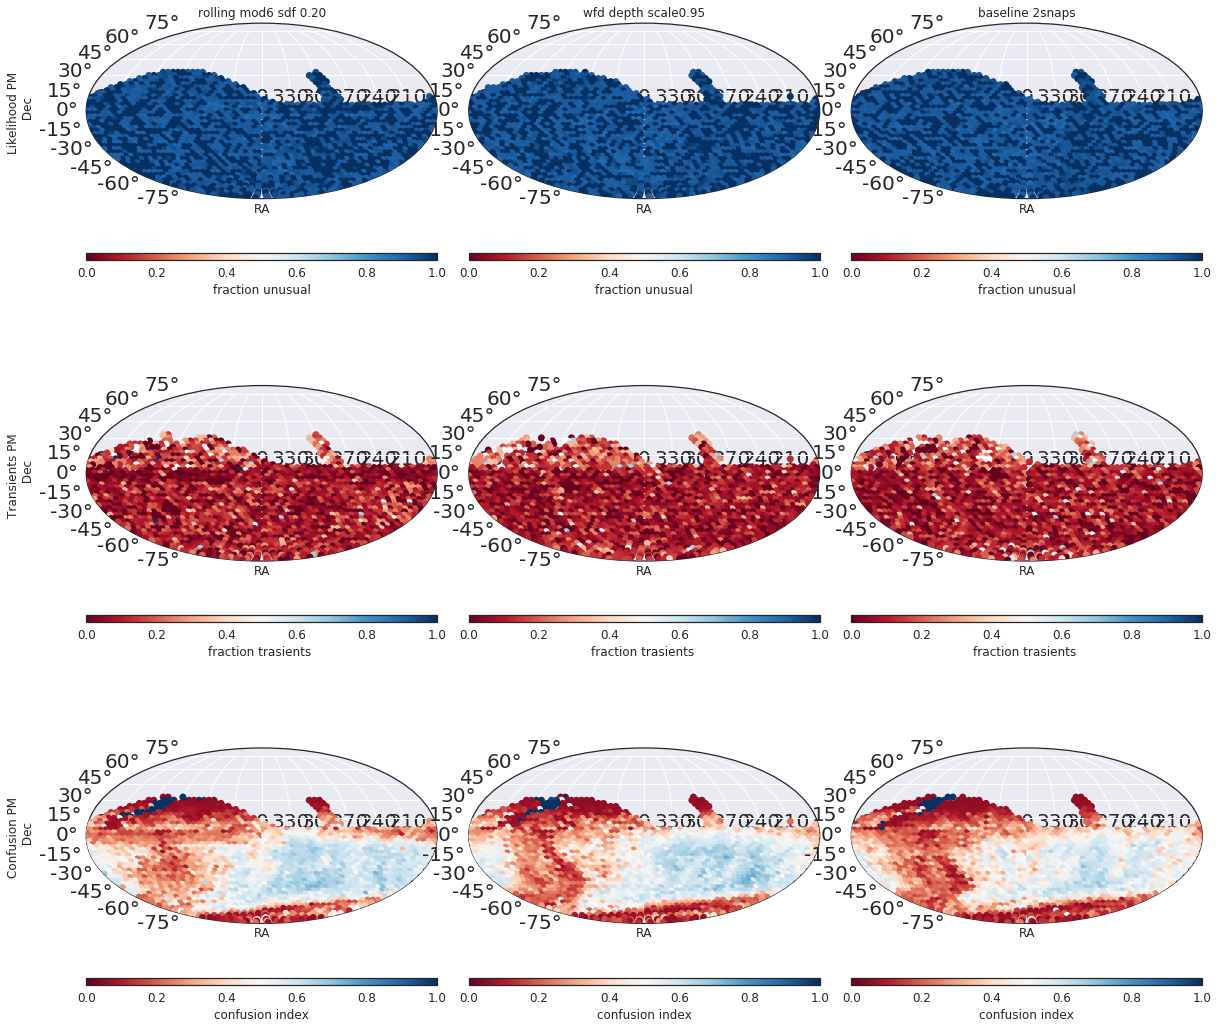

In [373]:
import matplotlib as mpl
from itertools import product 
import matplotlib.gridspec as gridspec
mpl.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,20))
outer_grid = gridspec.GridSpec(3, 3, wspace=0.09, hspace=0.0)
k = [k for k in df[dbRuns[0]].keys()]
for i, (metric, key) in enumerate(product([k[0],k[2],k[3],k[1]],['rolling_mod6_sdf_0.20_v1.5_10yrs','wfd_depth_scale0.95_v1.5_10yrs','baseline_2snaps_v1.5_10yrs'])):
    ra, dec = pix2radec(nside=16, ipix=df[key]['LSPMmetric']['pixID'].values)
    name = key.split('_') 
    name.remove('v1.5')
    name.remove('10yrs')
    name=' '.join(name)
    if metric == 'LSPMmetric':
        plt_mlw(ra,dec, c= df[key][metric]['detected'].values,ax=outer_grid[i],vmin=0,vmax=1, dicts={'cbartitle':'fraction unusual','title':name, 'colormap':'RdBu'} )
        if i ==0:
            plt.ylabel('Likelihood PM \n Dec')
        else:
            plt.ylabel('')
    if metric == 'TransienPM':
        plt_mlw(ra,dec, c= df[key][metric][0:len(ra)],ax=outer_grid[i],vmin=0,vmax=1, dicts={'cbartitle':'fraction trasients ', 'title':'','colormap':'RdBu'} )
        if i ==3:
            plt.ylabel('Transients PM \n Dec')
        else:
            plt.ylabel('')
    if metric == 'confusionmetric':
        plt_mlw(ra,dec, c= df[key][metric][0:len(ra)]*62,ax=outer_grid[i],vmin=0,vmax=1, dicts={ 'cbartitle':'confusion index','title':'','colormap':'RdBu'} )
        if i ==6:
            plt.ylabel('Confusion PM \n Dec')
        else:
            plt.ylabel('')
    #if metric == 'StarDensity ':
    #    p = np.convolve(df[key]['LSPMmetric']['detected'].values,df[key][metric],'same')
    #    plt_mlw(ra,dec, c= p[0:len(ra)]/max(p),ax=outer_grid[i],vmin=0,vmax=1, dicts={ 'cbartitle':'star density','title':'','colormap':'RdBu'} )
    #    if i ==9:
    #        plt.ylabel('Star Density PM \n Dec')
    #    else:
    #        plt.ylabel('')
    plt.savefig('SkyMap_astrometry.pdf')

In [372]:
df['baseline_v1.5_10yrs']['Like_point'].keys()

Index(['detected', 'pixID'], dtype='object')

In [366]:
hist_opsim = ['baseline_v1.5_10yrs','twilight_neo_mod2_v1.5_10yrs']
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
mpl.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,20))
outer_grid = gridspec.GridSpec(2, 2, wspace=0.09, hspace=0.0)
for opsim in hist_opsim:
df[]

array([1.00172124, 1.0195012 , 1.06747456, ..., 1.12884267, 1.08079408,
       1.03231432])

In [288]:
import pickle

with open('data_FromMetric.p','wb') as fp:
    pickle.dump(df,fp)

In [57]:
import pickle

with open('pm_like.p', 'wb') as fp:
    pickle.dump(pm, fp)

with open('star_density.p', 'wb') as fp:
    pickle.dump(stars, fp)
    
with open('confusion.p', 'wb') as fp:
    pickle.dump(conf, fp)

with open('transient.p', 'wb') as fp:
    pickle.dump(frac, fp)

In [19]:
import pickle
with open('pm_like.p','rb') as f:
    pm_pickle=pickle.load(f)
with open('star_density.p','rb') as f:
    star_pickle=pickle.load(f)
with open('confusion.p','rb') as f:
    conf_pickle=pickle.load(f)
with open('transient.p','rb') as f:
    trans_pickle=pickle.load(f)

In [19]:
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

In [349]:
from pylab import cm
def plt_mlw(ra,dec,org=0,projection='mollweide',ax=ax,c= 'null', vmin=0,vmax=1, dicts={}):
    args={'colormap': 'rainbow','marker':'o','linewidths':0,'title':'mlw_plot','xlabel':'x','ylabel':'y', 'fontsize':12,'cbartitle': 'score'}
    if dicts:
        args.update(dicts)
        
    cmap = cm.get_cmap(args['colormap'])
    if c =='null':
        c= np.ones(len(ra))
    else:
        c=c
     
    x = np.remainder(ra+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    #fig = plt.figure(=#figsize=(10, 5))
    ax = fig.add_subplot(ax, projection=projection)
    ax.set_title(args['title'])
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis    
    ax.title.set_fontsize(12)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    im=plt.scatter(np.radians(x),np.radians(dec),c=c,cmap=cmap, marker = args['marker'], vmin = vmin, vmax = vmax, linewidths = args['linewidths'], zorder = 10)
    #ax.tick_params('both', labelsize=14)
    cb=plt.colorbar(im,aspect=50,orientation='horizontal')
    cb.set_label(args['cbartitle'], size=12)
    for t in cb.ax.get_xticklabels():
         t.set_fontsize(12)

In [375]:
FomLS=np.empty(len(dbRuns)) 
FomPMT=np.empty(len(dbRuns)) 
FomC =np.empty(len(dbRuns)) 
#for i, key in enumerate(bundleDicts.keys()): 
for i, key in enumerate(dbRuns): 
    FomLS[i] = np.nanmedian(df[key]['LSPMmetric']['detected'].values) 
    FomC[i]=np.nanmedian(df[key]['confusionmetric'])/np.nanmax(df[key]['confusionmetric'])
    FomPMT[i] = np.nanmedian(df[key]['TransienPM'])
    
idx=np.argsort(FomC+FomPMT+FomLS) 
idx=idx[::-1]

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/lib/function_base.py:3525: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [47]:
df[key]['LSPMmetric'].keys()

Index(['detected', 'pixID'], dtype='object')

In [ ]:
output= pd.concat([pd.DataFrame(lam[key]) for key in bundleDicts.keys()],axis=1)
output.columns=bundleDicts.keys()
output.to_csv('likelihood_score_DD.csv', index=False)

In [265]:
name_tick=[] 
for key in dbRuns:#bundleDicts.keys(): 
#if 'noddf' in key: 
#    continue 
#else: 
    n= key.split('_') 
    if 'v1.5' in n: 
        n.remove('v1.5') 
    else: 
        word=[] 
        for s in n[-2]: 
            word.append(s) 
            word[0].replace('v','') 
            word[0].replace('1','')  
            word[0].replace('.','')  
            word[0].replace('5','')  
        sub ='' 
        n[-2]= sub.join(word) 
    n.remove('10yrs') 
    s=' ' 
    name_tick.append(s.join(n))

In [898]:
FomLS=np.empty(len(dbRuns)) 
FomPMT=np.empty(len(dbRuns)) 
FomC =np.empty(len(dbRuns)) 
#for i, key in enumerate(bundleDicts.keys()): 
for i, key in enumerate(dbRuns): 
 #if 'noddf' in key: 
 #    continue 
 #else: 
    if len(pm[key])>0: 
        pm[key]=np.array(pm[key],dtype=np.float64)[~np.isnan(np.array(pm[key],dtype=np.float64))]
        ID_pm=np.where((pm[key]<1)) 
         #lv,lb =np.histogram(np.array(pm[key])[ID_pm],'auto') 
         #l_fom = (lb[1:len(lb)]+lb[0:len(lb)-1])/2*lv 
         #FomLS.append(l_fom.sum()/lv.sum()/(3*np.std(np.array(pm[key])[ID_pm]))*np.mean(np.array(pm[key])[ID_pm])) 
        FomLS[i] = np.median(np.array(pm[key])[ID_pm])/(3*np.std(1-np.array(pm[key])[ID_pm])) 
    else: 
         FomLS[i] = np.nan 
         #FomLS.append(0) 
    if len(conf[key])>0:     
        conf[key]=np.array(conf[key],dtype=np.float64)[~np.isnan(np.array(conf[key],dtype=np.float64))]
        ID_conf=np.where((conf[key]!=0)) 
         #cv,cb =np.histogram(np.array(conf[key])[ID_conf],'auto') 
         #c_fom = (cb[1:len(cb)]+cb[0:len(cb)-1])/2*cv 
         #FomC.append(c_fom.sum()/cv.sum()/(np.std(np.array(conf[key])[ID_conf]))*norm_coeff[i]) 
        FomC[i]=np.absolute(np.median(np.array(conf[key])[ID_conf])/(3*np.std(np.array(conf[key])[ID_conf])))#/norm_coeff[i]*(len(ID_conf)) 
    else: 
         FomC[i] = np.nan 
         #FomC.append(0) 
    if len(frac[key])>0: 
        frac[key]=np.array(frac[key],dtype=np.float64)[~np.isnan(np.array(frac[key],dtype=np.float64))]
        ID_frac=np.where((np.isnan(frac[key])==False)) 
         #fv,fb=np.histogram(np.array(frac[key])[ID_frac],'auto')  
         #f_fom = (fb[1:len(fb)]+fb[0:len(fb)-1])/2*fv    
         #FomPMT.append(f_fom.sum()/fv.sum()*np.mean(np.array(frac[key])[ID_frac]))#/(3*np.std(np.array(frac[key])[ID_frac]))) 
        FomPMT[i] = np.absolute(np.median(np.array(frac[key])[ID_frac]))/(3*np.std(np.array(frac[key])[ID_frac])) 
    else: 
         FomPMT[i] = np.nan 
         #FomPMT.append(0) 
#FomLS=np.array(FomLS) 
#FomPMT=np.array(FomPMT) 
#FomC= np.array(FomC) 
idx=np.argsort(FomC+FomPMT+FomLS) 
idx=idx[::-1]

In [912]:
ScoreLS= pd.DataFrame(FomLS/3) 
ScoreLS.to_csv('Score_LS.cvs',index=False) 
ScoreCI= pd.DataFrame(FomC/3) 
ScoreCI.to_csv('Score_CI.cvs',index=False) 
ScorePMT= pd.DataFrame(FomPMT/3) 
ScorePMT.to_csv('Score_PMT.cvs',index=False)

In [293]:
FomLS = pd.read_csv('Score_LS.cvs') 
FomLS = np.array(FomLS['0']) 
FomC = pd.read_csv('Score_CI.cvs') 
FomC = np.array(FomC['0']) 
FomPMT = pd.read_csv('Score_PMT.cvs') 
FomPMT = np.array(FomPMT['0']) 
idx=np.argsort(FomC+FomPMT+FomLS) 
idx=idx[::-1]

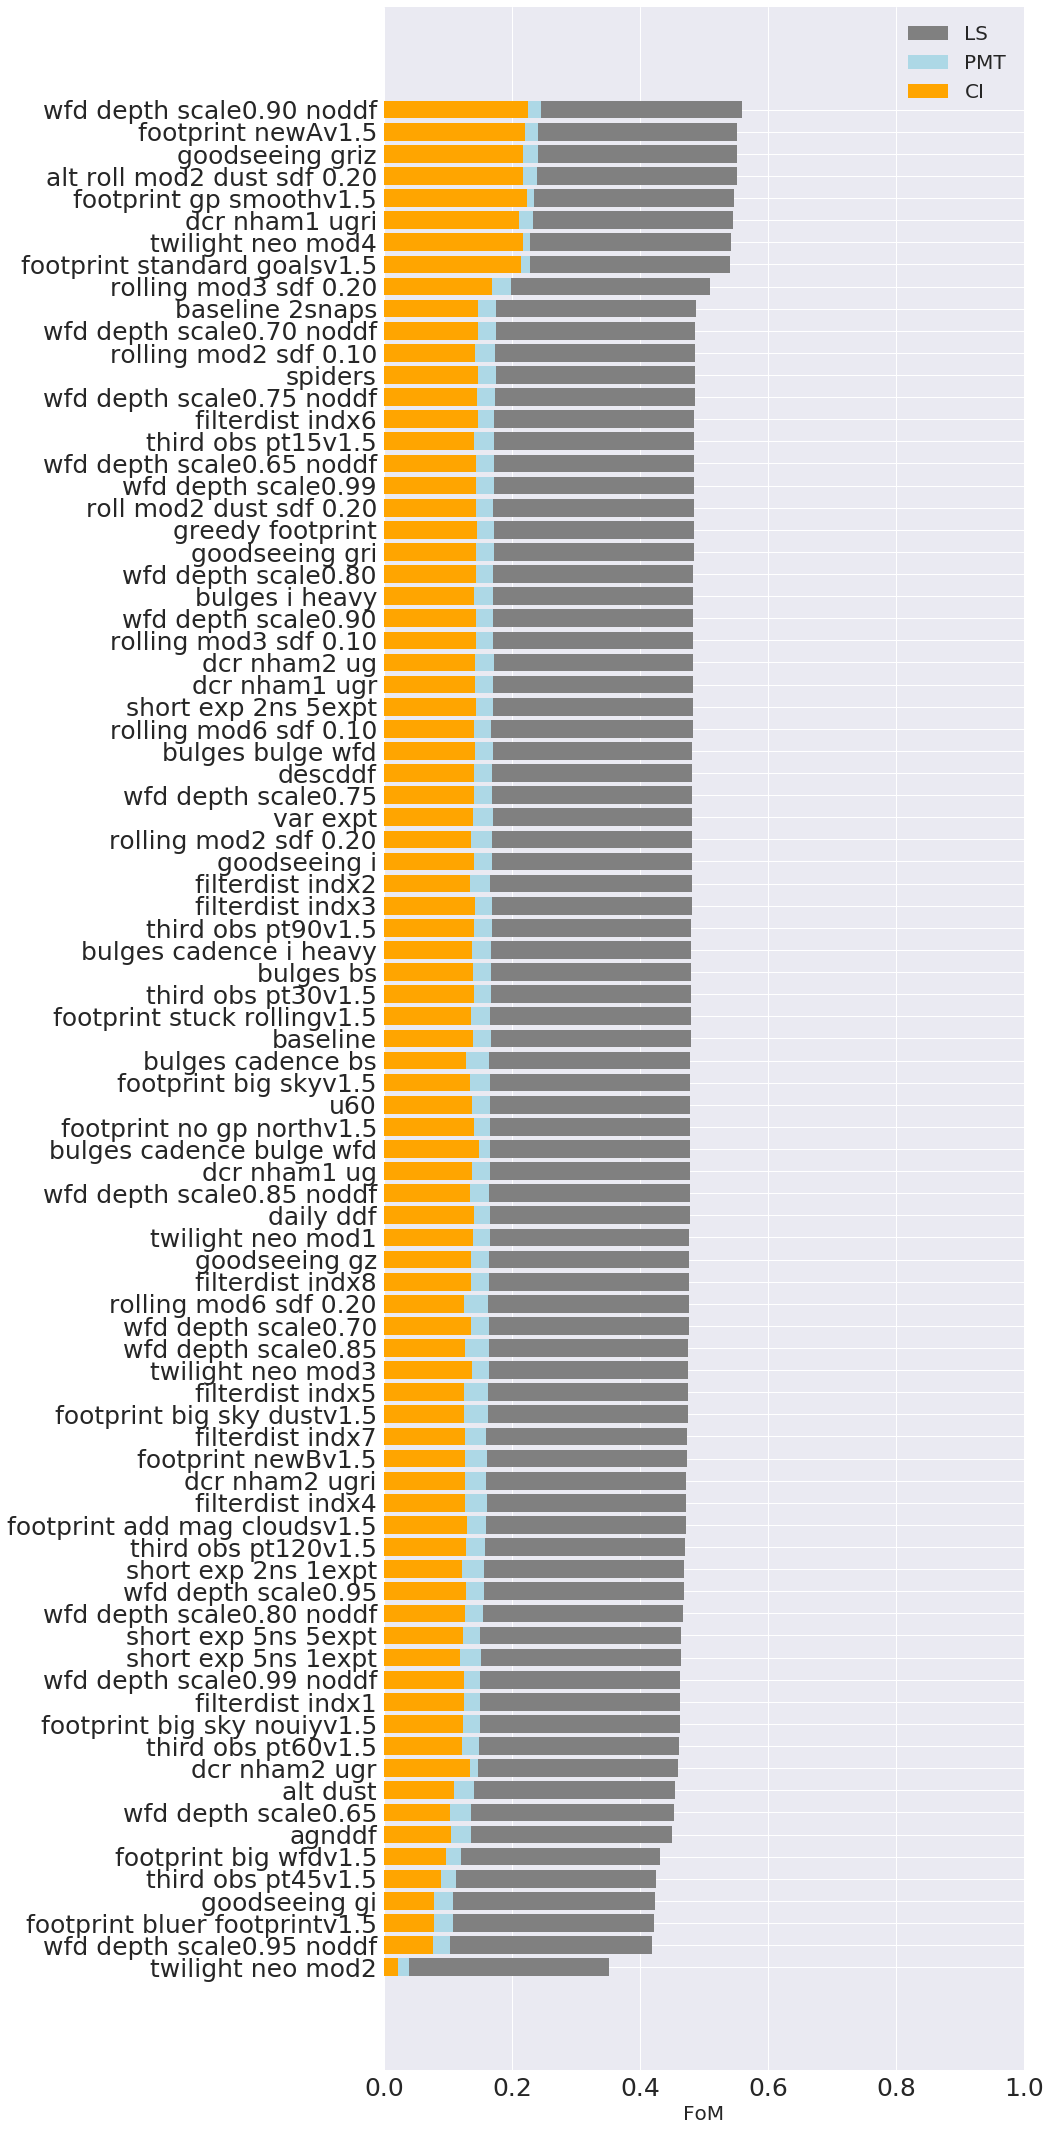

In [376]:
plt.style.use('seaborn') 
plt.rc('legend', fontsize=25) 
plt.rc('xtick',labelsize=25) 
fig, ax = plt.subplots(figsize=(15,30)) 
y_pos = np.arange(len(name_tick)) 
ax.barh(y_pos,(FomLS[idx]+FomC[idx]+FomPMT[idx])/3, align='center',color='grey',label='LS ') 
ax.barh(y_pos,(FomPMT[idx]+FomC[idx])/3, align='center',color='lightblue' ,label='PMT') 
ax.barh(y_pos,FomC[idx]/3, align='center', color= 'orange',label='CI') 
ax.set_xlim([0,1]) 
ax.set_yticks(y_pos[idx]) 
ax.set_yticklabels(name_tick, size=25) 
ax.invert_yaxis()  # labels read top-to-bottom 
ax.set_xlabel('FoM', size=20) 
ax.legend(bbox_to_anchor=(1,1),fontsize=20) 
plt.tight_layout() 
plt.savefig('FOM_astrometry_2yrs_v1p5.pdf')

In [294]:
df_plot = pd.DataFrame({'LS':FomLS/3,'CI':FomC/3,'PMT':FomPMT/3})

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


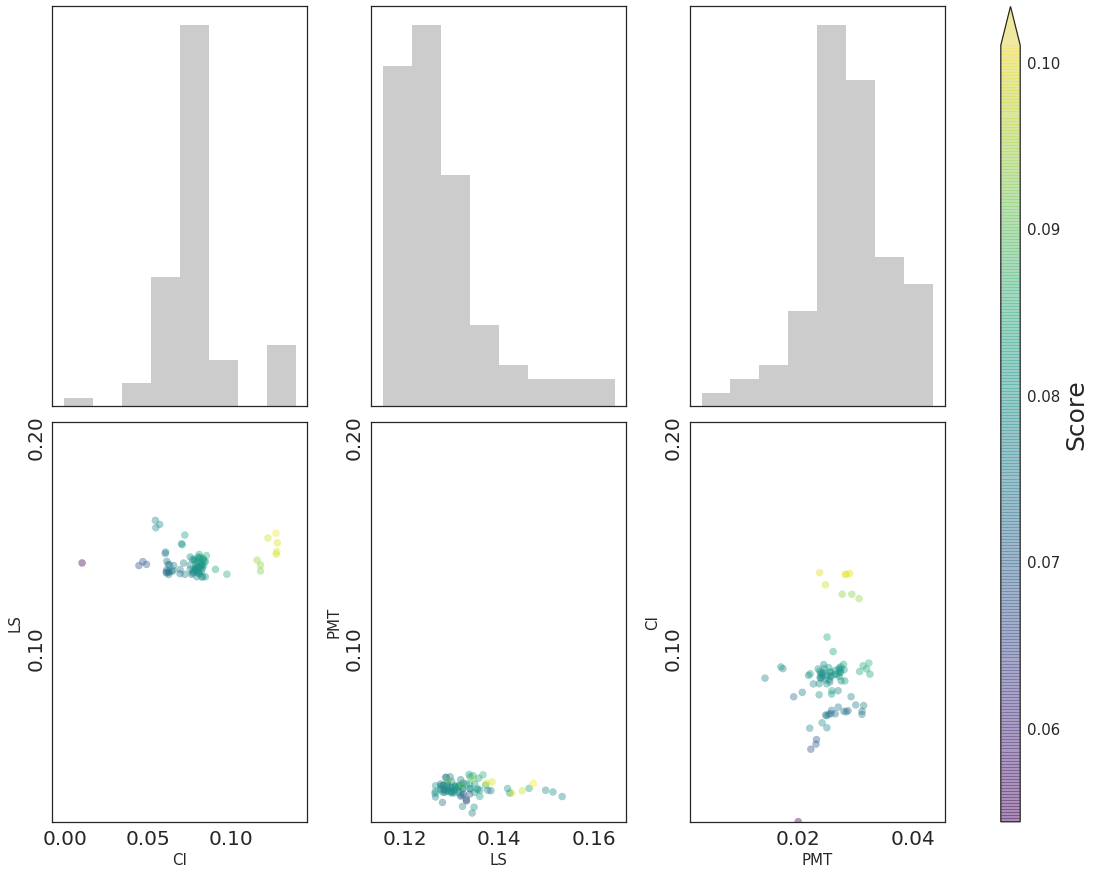

In [377]:
import matplotlib as mpl 
import seaborn as sns 
from scipy.stats import gaussian_kde
from matplotlib.ticker import FormatStrFormatter 
import matplotlib.gridspec as gridspec 
import matplotlib.ticker as plticker


mpl.rcParams.update({'font.size': 20}) 
#plt.rc('legend', fontsize=25) 
plt.rc('xtick',labelsize=20) 
plt.rc('ytick',labelsize=20) 
plt.rcParams['axes.grid']= False 
plt.rcParams['axes.edgecolor']= '0.15' 
plt.rcParams['axes.linewidth']= 1.25 
fig = plt.figure(figsize=(20,15)) 
grid = gridspec.GridSpec(2, 3, wspace=0.25, hspace=0.04) 
for i ,m in zip(np.arange(0,6,1), ['CI','LS','PMT']*2): 
    ax=plt.Subplot(fig, grid[i]) 
    if i in [0,1,2]: 
         #df_p=pd.DataFrame(df_plot[m]) 
        #sns.kdeplot(df_plot[m],color='gray', shade=True,ax=ax, alpha=0.3, legend=False) 
        sns.distplot(df_plot[m],color='gray',hist=True,kde=False,bins=8,ax=ax)
     #ax.hist(df_plot[m], bins='auto', histtype='step',lw=2,color='k') 
        ax.patch.set_facecolor('white') 
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 
        fig.add_subplot(ax) 

    else: 
        if i ==3: 
            xy = np.vstack([df_plot['CI'],df_plot['LS']]) 
            z = gaussian_kde(xy)(xy) 
            ax.scatter(df_plot['CI'],df_plot['LS'],c=(df_plot['CI']+df_plot['PMT']+df_plot['LS'])/3, s=50,cmap='viridis', marker='o',alpha=.4) 
            ax.grid(False) 
            loc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
            ax.yaxis.set_major_locator(loc)
            ax.set_ylim([0.01,0.2]) 
            ax.patch.set_facecolor('white') 
            ax.set_ylabel('LS', fontsize=15) 
            ax.set_xlabel('CI', fontsize=15) 
            #ax.xaxis.set_tick_params(rotation=90)
            ax.yaxis.set_tick_params(rotation=90)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
        elif i ==4: 
            xy = np.vstack([df_plot['LS'],df_plot['PMT']]) 
            z = gaussian_kde(xy)(xy) 
            ax.scatter(df_plot['LS'],df_plot['PMT'], c=(df_plot['CI']+df_plot['PMT']+df_plot['LS'])/3,s=50,cmap='viridis', marker='o',alpha=.4) 
            ax.grid(False) 
            ax.set_ylim([0.01,0.2]) 
            loc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
            ax.yaxis.set_major_locator(loc)
            ax.patch.set_facecolor('white') 
            ax.set_xlabel('LS', fontsize=15) 
            ax.set_ylabel('PMT', fontsize=15) 
            #ax.xaxis.set_tick_params(rotation=90)
            ax.yaxis.set_tick_params(rotation=90)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
        elif i ==5: 
            xy = np.vstack([df_plot['LS'],df_plot['PMT']]) 
            z = gaussian_kde(xy)(xy) 
            ax.scatter(df_plot['PMT'],df_plot['CI'], c=(df_plot['CI']+df_plot['PMT']+df_plot['LS'])/3,s=50,cmap='viridis', marker='o',alpha=.4) 
            ax.grid(False)          
            ax.set_ylim([0.01,0.2]) 
            loc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
            ax.yaxis.set_major_locator(loc)
            ax.set_xlabel('PMT', fontsize=15) 
            ax.set_ylabel('CI', fontsize=15) 
            ax.patch.set_facecolor('white') 
            #ax.xaxis.set_tick_params(rotation=90)
            ax.yaxis.set_tick_params(rotation=90)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
        fig.add_subplot(ax) 

all_axes = fig.get_axes() 
cax,kw = mpl.colorbar.make_axes([axs for axs in all_axes], aspect=40) 
cbar= plt.colorbar(all_axes[3].get_children()[0],extend='max', cax=cax,**kw) 
#cbar.set_ticks([]) 
cbar.ax.tick_params(labelsize=15)  
cbar.set_label('Score', size=25) 
fig.tight_layout() 
fig.show() 
fig.savefig('corner_score.pdf')

# PM distribution

In [ ]:
hist_opsim = ['baseline_v1.5_10yrs','twilight_neo_mod2_v1.5_10yrs']
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
mpl.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(20,20))
outer_grid = gridspec.GridSpec(2, 2, wspace=0.15, hspace=0.2)
for i, (opsim,point) in enumerate(product(hist_opsim,[0,1])):
    
    if opsim== 'baseline_v1.5_10yrs' and point ==1:
        ax = fig.add_subplot(outer_grid[i])
        ax.hist(df[opsim]['Like_point']['PM_OUT'].values[point], bins=50, color='#ff7f00',linestyle='solid',histtype='step', lw=4,alpha =.5, label= 'unusual')
        ax.hist(df[opsim]['Like_point']['PM'].values[point], bins=20, color= '#a65628',linestyle='dashed',histtype='step',lw=4, alpha =.6, label='usual')
        ax.set_xlabel('pm [\'\'/yr]', size=25)
        ax.legend(loc='upper right',fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_ylabel('N', size=25)
        ax.set_xlim([-0.015,0.015])
        #good=(data[key][0]['LS']['PM']< 0.03) & (hist[metric_runs[0]]['PM']>-0.03)
        quant = np.percentile(df[dbRuns[49]]['Like_point']['PM'].values[1],[2.5,97.5,50])
        y_min, y_max = ax.get_ylim()
        x_min, x_max = ax.get_xlim()
        deltax =np.absolute(y_min -y_max)
        deltay =np.absolute(x_min -x_max)
        ra,dec=pix2radec(16,df[opsim]['Like_point']['pixID'].values[point])
        ax.text(x_min+0.001,135,'ra,dec ='+str(np.round(ra,2))+','+str(np.round(dec,2)),fontsize=14)
        ax.text(x_min+0.001,129,r'$\bar{\mu}_{usual}=$'+str(np.round(quant[2],5))+'"/yr',fontsize=14)
    else:
        ax = fig.add_subplot(outer_grid[i])
        ax.hist(df[opsim]['Like_point']['PM_OUT'].values[point], bins=100, color='#ff7f00',linestyle='solid',histtype='step', lw=4,alpha =.5, label= 'unusual')
        ax.hist(df[opsim]['Like_point']['PM'].values[point], bins=50, color= '#a65628',linestyle='dashed',histtype='step',lw=4, alpha =.6, label='usual')
        ax.set_xlabel('pm [\'\'/yr]', size=25)
        ax.legend(loc='upper right',fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_ylabel('N', size=25)
        ax.set_xlim([-0.01,0.01])
        #good=(data[key][0]['LS']['PM']< 0.03) & (hist[metric_runs[0]]['PM']>-0.03)
        quant = np.percentile(df[dbRuns[49]]['Like_point']['PM'].values[point],[2.5,97.5,50])
        y_min, y_max = ax.get_ylim()
        x_min, x_max = ax.get_xlim()
        deltax =np.absolute(y_min -y_max)
        deltay =np.absolute(x_min -x_max)
        ra,dec=pix2radec(16,df[opsim]['Like_point']['pixID'].values[point])
        ax.text(x_min+0.001,2000,'ra,dec ='+str(np.round(ra,2))+','+str(np.round(dec,2)),fontsize=14)
        ax.text(x_min+0.001,1900,r'$\bar{\mu}_{usual}=$'+str(np.round(quant[2],5))+'"/yr',fontsize=14)
    ax.axvline(quant[2], color='k', alpha=.3, linestyle='dotted', linewidth=3)
    ax.axvline(quant[0], color='k', linestyle='dotted', linewidth=3)
    ax.axvline(quant[1], color='k', linestyle='dotted', linewidth=3)
    name = opsim.split('_') 
    name.remove('v1.5')
    name.remove('10yrs')
    name=' '.join(name)
    ax.set_title(name, fontsize=25)
    #plt.ylim([0,12000])
    plt.savefig('galactic_histograms.pdf')
    #plt.show()

### Sgr Simulation

In [ ]:
dataout_dens, cind_dens,H_dens,c_dens={},{},{},{}
for key in bundleDicts.keys():
    dataout_dens[key]=pd.DataFrame(bundleDicts[key][(1,'confusionmetric')].metricValues[np.where(bundleDicts[key][(1,'confusionmetric')].metricValues.mask == False)])[0]
    cind_dens[key]= {}
    H_dens[key]= {}
    c_dens[key]= {}
    for mag in dataout_dens[key][0].keys(): 
        cind_dens[key][mag] = []
        H_dens[key][mag] = []
        c_dens[key][mag] = []
    for i in range(len(dataout_dens[key])):        
        if dataout_dens[key][i]:
            for mag in dataout_dens[key][i].keys():
                cind_dens[key][mag].append(dataout_dens[key][i][mag]['num'])
                H_dens[key][mag].append(dataout_dens[key][i][mag]['Hg'])
                c_dens[key][mag].append(dataout_dens[key][i][mag]['g-r'])
    for mag in dataout_dens[key][0].keys(): 
        cind_dens[key][mag]=np.hstack(np.array(cind_dens[key][mag])[np.isfinite(np.array(cind_dens[key][mag]))])
        H_dens[key][mag]=np.hstack(np.array(H_dens[key][mag])[np.isfinite(np.array(H_dens[key][mag]))])
        c_dens[key][mag]=np.hstack(np.array(c_dens[key][mag])[np.isfinite(np.array(c_dens[key][mag]))])   

In [ ]:
dataout, cind_dist,H_dist,c_dist, label={},{},{},{},{}
for key in bundleDicts.keys():
    dataout[key]=pd.DataFrame(bundleDicts[key][(1,'confusionmetric')].metricValues[np.where(bundleDicts[key][(1,'confusionmetric')].metricValues.mask == False)])[0]
    cind_dist[key]= {}
    H_dist[key]= {}
    c_dist[key]= {}
    for mag in dataout[key][0].keys(): 
        cind_dist[key][mag] = []
        H_dist[key][mag] = []
        c_dist[key][mag] = []
    for i in range(len(dataout[key])):        
        if dataout[key][i]:
            for mag in dataout[key][i].keys():
                cind_dist[key][mag].append(dataout[key][i][mag]['num'])
                H_dist[key][mag].append(dataout[key][i][mag]['Hg'])
                c_dist[key][mag].append(dataout[key][i][mag]['g-r'])
    for mag in dataout[key][0].keys(): 
        cind_dist[key][mag]=np.hstack(np.array(cind_dist[key][mag])[np.isfinite(np.array(cind_dist[key][mag]))])
        H_dist[key][mag]=np.hstack(np.array(H_dist[key][mag])[np.isfinite(np.array(H_dist[key][mag]))])
        c_dist[key][mag]=np.hstack(np.array(c_dist[key][mag])[np.isfinite(np.array(c_dist[key][mag]))])
    

In [ ]:
import matplotlib as mpl
from itertools import product 
import matplotlib.gridspec as gridspec
for j, tup in enumerate([(3, 'PM2yrs')]):#enumerate([(2, 'PM5yrs'), (3, 'PM2yrs'), (4, 'PM1yrs'), (5, 'PM0p5yrs')]):
    mpl.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(30,30))
    outer_grid = gridspec.GridSpec(4, 4, wspace=0.0, hspace=0.04)
    for i, (mag, key) in enumerate(product([0,1,2,3],dbRuns[0:4])):
        n=key.split('_')
        n.remove('v1.4')
        n.remove('10yrs')
        sep='_'
        name= sep.join(n)
        inner_grid = gridspec.GridSpecFromSubplotSpec(
          2, 1, subplot_spec=outer_grid[i], wspace=0.0, hspace=0.0)
        for j, mode in enumerate(['density','distance']):
            ax = plt.Subplot(fig, inner_grid[j])
            ax = plt.Subplot(fig, inner_grid[j], sharey=ax, sharex=ax)

            if mode=='density'and i>=4 and i not in [0,4,8,12,13,14,15]:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            if mode=='distance'and i>=4 and i not in [0,4,8,12,13,14,15]:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue

            elif mode=='density'and i in [4,8]:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('Hg')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='distance'and i in [4,8]:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='density' and i in [1,2,3]:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2,title='{} '.format(name))

                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='distance' and i in [1,2,3]:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='density' and i==0:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2,title='{} '.format(name))

                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('Hg')
                    im.set_xlabel('')
                    im.invert_yaxis()
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='distance' and i==0:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.invert_yaxis()
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='density'and i==12:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('Hg')
                    im.set_xlabel('')
                    fig.add_subplot(ax)
                except:
                    continue
            if mode=='distance'and i==12:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_xlim([0,1.9])
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('')
                    fig.add_subplot(ax)  
                except:
                    continue
            elif mode== 'distance' and i in [13,14,15]:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.set_ylabel('')
                    im.set_xlim([0,1.9])
                    im.invert_yaxis()
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode== 'density' and i in [13,14,15]:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.set_ylabel('')
                    im.invert_yaxis()
                    im.get_yaxis().set_visible(False)
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
    plt.suptitle("ConfunsionIndex {}".format(tup[1]))
    all_axes = fig.get_axes()
    fig.tight_layout()
    cax,kw = mpl.colorbar.make_axes([axs for axs in all_axes], aspect=40)
    cbar= plt.colorbar(all_axes[0].get_children()[0], extend= 'max',cax=cax,**kw)
    cbar.ax.set_ylabel('Confusion Index', size=30)
    fig.savefig("ConfunsionIndex_{}.png".format(tup[1]))


In [109]:
dvel= pd.read_csv('v_hel.csv')
drpm = pd.read_csv('data.csv')

In [170]:
val, bins=np.histogram(np.array(dvel['VHEL'])[np.where(dvel['VHEL']<500)],bins='auto')

In [192]:
def Gauss2(x,A1,A2,mu1,mu2,sigma1,sigma2):
    return A1*np.exp(-0.5*((mu1-x)/sigma1)**2)+A2*np.exp(-0.5*((mu2-x)/sigma2)**2)

In [193]:
from scipy.optimize import curve_fit 

In [196]:
fit, cov = curve_fit(Gauss2, bins[0:-1],val,p0=[1,1,np.mean(bins),np.mean(bins),np.std(bins),np.std(bins)])

In [197]:
fit

array([ 51.02292506,  17.14810292,  -9.78277474, -97.29040162,
       -32.25334926, 106.91821735])

In [206]:
vel_unusual =np.exp(-0.5*((fit[3]-np.arange(-500,300,1))/fit[5])**2)

In [208]:
vel_unusual= pd.DataFrame({'vel':np.arange(-500,300,1),'fraction':vel_unusual})

In [211]:
vel_unusual.to_csv('unusual_stream.csv', index=False)